## Extractive Summary : BERT + Unsupervised Learning 

In [7]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np
import torch
import os
import json
from rouge_score import rouge_scorer
from statistics import mean
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")
import pickle
from datasets import DatasetDict
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [71]:
name_of_model = "bert-base-multilingual-cased"

In [72]:
model_tokenizer = AutoTokenizer.from_pretrained(name_of_model)
model_base = AutoModel.from_pretrained(name_of_model)

In [17]:
canonical_test = os.listdir(os.path.join(os.path.abspath(os.getcwd()),"./liputan6_data/canonical/test"))[:100]

In [74]:
input_ids = []
def tokenisasi(per_sentence:list) : 
    kata = []
    global input_ids
    for raw_kata in per_sentence : 
        kata.append(raw_kata.lower())
    inputs = model_tokenizer(kata, is_split_into_words = True, return_attention_mask = True, return_tensors = "pt", padding = "max_length", truncation = True, max_length = 128)
    with torch.no_grad() : 
        hasil = torch.mean(model_base(**inputs).last_hidden_state, axis = 1)
    input_ids.append(hasil[0].tolist())

In [75]:
modelKNN = KMeans(n_clusters = 2, random_state = 42, init = "k-means++", max_iter = 500, n_init = 10)

In [76]:
rougeScorer = rouge_scorer.RougeScorer(rouge_types=["rougeL","rouge1","rouge2"])

In [77]:
rougeL = []
rouge1 = []
rouge2 = []

In [119]:
for index,file in enumerate(canonical_test) : 
    print(f"Fetched {index+1} files")
    with open(os.path.join(os.path.abspath(os.getcwd()),"./liputan6_data/canonical/test",file),"r") as f :
        data = json.load(f)
    input_ids = []
    for i in data["clean_article"] : 
        tokenisasi(i)
    hasil = modelKNN.fit_predict(input_ids)
    jawaban_summary = []
    for i in modelKNN.cluster_centers_ : 
        jawaban_summary.append(int(np.argmin(np.linalg.norm(input_ids - i, axis = -1),-1)))
    jawaban_summary.sort()
    hasil_summary = ""
    for i in jawaban_summary : 
        hasil_summary += " ".join(data["clean_article"][i])
        hasil_summary+=" "
    real_summary = ""
    for i in data["clean_summary"] : 
        real_summary+=" ".join(i)
        real_summary+=" "
    rougeL.append(rougeScorer.score(hasil_summary,real_summary)["rougeL"].fmeasure)
    rouge1.append(rougeScorer.score(hasil_summary,real_summary)["rouge1"].fmeasure) 
    rouge2.append(rougeScorer.score(hasil_summary,real_summary)["rouge2"].fmeasure)

Fetched 1 files
Fetched 2 files
Fetched 3 files
Fetched 4 files
Fetched 5 files
Fetched 6 files
Fetched 7 files
Fetched 8 files
Fetched 9 files
Fetched 10 files
Fetched 11 files
Fetched 12 files
Fetched 13 files
Fetched 14 files
Fetched 15 files
Fetched 16 files
Fetched 17 files
Fetched 18 files
Fetched 19 files
Fetched 20 files
Fetched 21 files
Fetched 22 files
Fetched 23 files
Fetched 24 files
Fetched 25 files
Fetched 26 files
Fetched 27 files
Fetched 28 files
Fetched 29 files
Fetched 30 files
Fetched 31 files
Fetched 32 files
Fetched 33 files
Fetched 34 files
Fetched 35 files
Fetched 36 files
Fetched 37 files
Fetched 38 files
Fetched 39 files
Fetched 40 files
Fetched 41 files
Fetched 42 files
Fetched 43 files
Fetched 44 files
Fetched 45 files
Fetched 46 files
Fetched 47 files
Fetched 48 files
Fetched 49 files
Fetched 50 files
Fetched 51 files
Fetched 52 files
Fetched 53 files
Fetched 54 files
Fetched 55 files
Fetched 56 files
Fetched 57 files
Fetched 58 files
Fetched 59 files
Fetche

In [58]:
resultRouge1 = []
resultRouge2 = []
resultRougeL = []

In [79]:
resultRouge1.append(mean(rouge1))
resultRouge2.append(mean(rouge2))
resultRougeL.append(mean(rougeL))

In [ ]:
print("Hasil ROUGE indobenchmark/indobert-base-p1 : ")
print(f"Rouge1 : {mean(rouge1)}")
print(f"Rouge2 : {mean(rouge2)}")
print(f"RougeL : {mean(rougeL)}")

Hasil ROUGE indobenchmark/indobert-base-p1 : 
Rouge1 : 0.25990303133362863
Rouge2 : 0.11538311450870564
RougeL : 0.1951352407188512


In [70]:
print("Hasil ROUGE LazarusNLP/all-nusabert-large-v4 : ")
print(f"Rouge1 : {mean(rouge1)}")
print(f"Rouge2 : {mean(rouge2)}")
print(f"RougeL : {mean(rougeL)}")

Hasil ROUGE LazarusNLP/all-nusabert-large-v4 : 
Rouge1 : 0.2793898032352043
Rouge2 : 0.1297500899335427
RougeL : 0.21002421944305671


In [80]:
print("Hasil ROUGE bert-base-multilingual-cased : ")
print(f"Rouge1 : {mean(rouge1)}")
print(f"Rouge2 : {mean(rouge2)}")
print(f"RougeL : {mean(rougeL)}")

Hasil ROUGE bert-base-multilingual-cased : 
Rouge1 : 0.24746459966733236
Rouge2 : 0.10289385400388482
RougeL : 0.18643407239878146


In [99]:
rouge1List = [0.25990303133362863,0.2793898032352043,0.24746459966733236]
rouge2List = [0.11538311450870564,0.1297500899335427,0.10289385400388482]
rougeLList = [0.1951352407188512,0.21002421944305671,0.18643407239878146]
labelRouge = ["indobert-base-p1","all-nusabert-large","bert-base-multilingual"]

In [100]:
import matplotlib.pyplot as plt

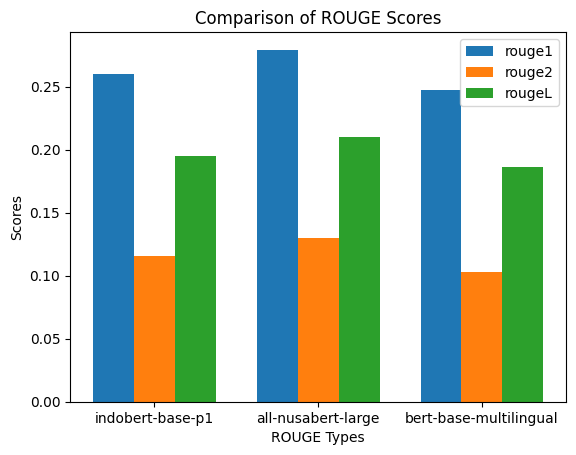

In [101]:
x = np.arange(len(labelRouge)) 
width = 0.25

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, rouge1List, width, label='rouge1')
rects2 = ax.bar(x, rouge2List, width, label='rouge2')
rects3 = ax.bar(x + width, rougeLList, width, label='rougeL')

ax.set_xlabel('ROUGE Types')
ax.set_ylabel('Scores')
ax.set_title('Comparison of ROUGE Scores')
ax.set_xticks(x)
ax.set_xticklabels(labelRouge)
ax.legend()

plt.show()

## Text Rank Algorithms : 

In [2]:
name_of_model = "LazarusNLP/all-nusabert-large-v4" 
model_tokenizer = AutoTokenizer.from_pretrained(name_of_model)
model_base = AutoModel.from_pretrained(name_of_model)

In [3]:
rougeScorer = rouge_scorer.RougeScorer(["rougeL", "rouge1", "rouge2"])

In [23]:
def sentence_similarity(sent1, sent2, model_tokenizer, model_base):
    tokens1 = model_tokenizer.encode(sent1, add_special_tokens=True)
    tokens2 = model_tokenizer.encode(sent2, add_special_tokens=True)
    
    input_ids1 = torch.tensor(tokens1).unsqueeze(0)
    input_ids2 = torch.tensor(tokens2).unsqueeze(0)
    with torch.no_grad():
        outputs1 = model_base(input_ids1)
        outputs2 = model_base(input_ids2)
        
    emb1 = outputs1[0][:, 0, :].numpy()
    emb2 = outputs2[0][:, 0, :].numpy()
    
    return cosine_similarity(emb1, emb2)[0][0]

In [ ]:
def textrank_summarization(file_path, model_tokenizer, model_base, rouge_scorer):
    with open(file_path, "r") as f:
        data = json.load(f)
    
    sentences = [" ".join(sentence) for sentence in data["clean_article"]] 
    
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            sim_score = sentence_similarity(sentences[i], sentences[j], model_tokenizer, model_base)
            similarity_matrix[i][j] = sim_score
            similarity_matrix[j][i] = sim_score  
    
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph, alpha=0.85)
    
    ranked_sentences = sorted(((score, i) for i, score in scores.items()), reverse=True)
    
    top_n_sentences = [sentences[i] for _, i in ranked_sentences[:2]] 
    summary = " ".join(top_n_sentences)
    
    real_summary = " ".join([" ".join(sentence) for sentence in data["clean_summary"]])
    
    rougeL = rouge_scorer.score(summary, real_summary)["rougeL"].fmeasure
    rouge1 = rouge_scorer.score(summary, real_summary)["rouge1"].fmeasure
    rouge2 = rouge_scorer.score(summary, real_summary)["rouge2"].fmeasure
    
    return rougeL, rouge1, rouge2, summary, real_summary

In [25]:
file_path = './liputan6_data/canonical/test/13019.json'

In [26]:
rougeL, rouge1, rouge2, generated_summary, real_summary = textrank_summarization(file_path, model_tokenizer, model_base, rougeScorer)

In [31]:
print("Hasil ROUGE LazarusNLP/all-nusabert-large-v4 [Text Rank Summarization]: ")
print(f"Rouge1 : {rouge1}")
print(f"Rouge2 : {rouge2}")
print(f"RougeL : {rougeL}")

Hasil ROUGE LazarusNLP/all-nusabert-large-v4 [Text Rank Summarization]: 
Rouge1 : 0.14634146341463414
Rouge2 : 0.05128205128205128
RougeL : 0.14634146341463414
